In [3]:
# ==============================================================
# LSTM-RNN From Scratch for RML2018.01A Dataset (24 Classes)
# ==============================================================

import h5py, ast, numpy as np, tensorflow as tf, matplotlib.pyplot as plt, seaborn as sns
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from pathlib import Path
import os

# --------------------------------------------------------------
# Resolve paths relative to project root
# --------------------------------------------------------------
notebook_dir = Path().resolve()
project_root = notebook_dir.parent  # notebooks/ → repo root

data_root = project_root / "data" / "RML2018" 
model_out = project_root / "models" / "rml2018_lstm_rnn.keras"

print("Notebook:", notebook_dir)
print("Data directory:", data_root)
print("Model will be saved to:", model_out)

# -------------------- Parameters --------------------
SNR_RANGE = (12, 20)
MAX_SAMPLES_PER_CLASS = 3000
EPOCHS = 250
BATCH_SIZE = 64
LR = 1e-4

# -------------------- Load Data ---------------------
def load_rml2018(h5_path, classes_txt, snr_range=(12,20)):
    with open(classes_txt, "r") as f:
        class_list = ast.literal_eval(f.read().split("=")[-1].strip())
        class_list = [c.strip(" '") for c in class_list]

    with h5py.File(h5_path, "r") as f:
        X, Y, Z = f["X"][:], f["Y"][:], f["Z"][:]

    per_class = {cls: [] for cls in class_list}
    for i in range(len(X)):
        snr = int(Z[i][0])
        if snr_range[0] <= snr <= snr_range[1]:
            label_idx = int(Y[i].argmax())
            cls = class_list[label_idx]
            sig = np.hstack([X[i], np.full((1024,1), snr, dtype=np.float32)])
            per_class[cls].append(sig)

    # Trim to max samples
    for k in per_class:
        per_class[k] = per_class[k][:MAX_SAMPLES_PER_CLASS]

    return per_class

# Paths updated here:
h5_file = data_root / "GOLD_XYZ_OSC.0001_1024.hdf5"
classes_file = data_root / "classes.txt"

data = load_rml2018(h5_file, classes_file)

# -------------------- Prepare Dataset ---------------------
X, y = [], []
for cls, samples in data.items():
    X.extend(samples)
    y.extend([cls] * len(samples))

X = np.array(X, dtype=np.float32)
y = np.array(y)

le = LabelEncoder()
y_enc = le.fit_transform(y)
n_classes = len(le.classes_)
print("Classes:", le.classes_)

# -------------------- Split Dataset ---------------------
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y_enc, test_size=0.2, stratify=y_enc, random_state=42
)
print("Train/Test split:", X_tr.shape, X_te.shape)

# -------------------- Build Model ---------------------
def build_model(input_shape, n_classes, lr=1e-4):
    model = Sequential([
        LSTM(128, input_shape=input_shape, return_sequences=True),
        Dropout(0.5),
        LSTM(128, return_sequences=False),
        Dropout(0.2),
        Dense(128, activation="relu"),
        Dropout(0.1),
        Dense(n_classes, activation="softmax")
    ])
    model.compile(
        optimizer=Adam(lr),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

model = build_model((1024, 3), n_classes, LR)
model.summary()

# -------------------- Train Model ---------------------
history = model.fit(
    X_tr, y_tr,
    validation_data=(X_te, y_te),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=2
)

# -------------------- Save Model ---------------------
model.save(model_out)
print("Model saved to:", model_out)

# -------------------- Evaluate ---------------------
y_prob = model.predict(X_te, verbose=0)
y_pred = np.argmax(y_prob, axis=1)

print("\nClassification Report:")
print(classification_report(y_te, y_pred, target_names=le.classes_))

cm = confusion_matrix(y_te, y_pred)
plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=False, cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix – RML2018 (24 Classes)")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


Notebook: /home/rameyjm7/workspace/ML-wireless-signal-classification/notebooks
Data directory: /home/rameyjm7/workspace/ML-wireless-signal-classification/data/RML2018
Model will be saved to: /home/rameyjm7/workspace/ML-wireless-signal-classification/models/rml2018_lstm_rnn.keras
Classes: ['128APSK' '128QAM' '16APSK' '16PSK' '16QAM' '256QAM' '32APSK' '32PSK'
 '32QAM' '4ASK' '64APSK' '64QAM' '8ASK' '8PSK' 'AM-DSB-SC' 'AM-DSB-WC'
 'AM-SSB-SC' 'AM-SSB-WC' 'BPSK' 'FM' 'GMSK' 'OOK' 'OQPSK' 'QPSK']
Train/Test split: (57600, 1024, 3) (14400, 1024, 3)


I0000 00:00:1763356704.792284 3136915 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 491 MB memory:  -> device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0000:3b:00.0, compute capability: 7.0
/home/rameyjm7/workspace/ml-env/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1024, 128)      │        67,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 24)             │         3,096 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 218,776 (854.59 KB)

 Trainable params: 218,776 (854.59 KB)

 Non-trainable params: 0 (0.00 B)

2025-11-17 00:18:37.905000: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:501] Allocator (GPU_0_bfc) ran out of memory trying to allocate 675.00MiB (rounded to 707788800)requested by op _EagerConst
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2025-11-17 00:18:37.905026: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1049] BFCAllocator dump for GPU_0_bfc
2025-11-17 00:18:37.905036: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1056] Bin (256): 	Total Chunks: 26, Chunks in use: 26. 6.5KiB allocated for chunks. 6.5KiB in use in bin. 272B client-requested in use in bin.
2025-11-17 00:18:37.905040: I external/local_xla/xla/tsl/framework/bfc_allocator.cc:1056] Bin (512): 	Total Chunks: 1, Chunks in use: 1. 512B allocated for chunks. 512B in use in bin. 512B client-requested in use in bin.
2025-11-17 00:18

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

2025-05-07 11:29:30.259397: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-07 11:29:30.274882: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746631770.288005 2470775 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746631770.291890 2470775 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-07 11:29:30.305663: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Classes (24): ['128APSK' '128QAM' '16APSK' '16PSK' '16QAM' '256QAM' '32APSK' '32PSK'
 '32QAM' '4ASK' '64APSK' '64QAM' '8ASK' '8PSK' 'AM-DSB-SC' 'AM-DSB-WC'
 'AM-SSB-SC' 'AM-SSB-WC' 'BPSK' 'FM' 'GMSK' 'OOK' 'OQPSK' 'QPSK']


I0000 00:00:1746631824.650249 2470775 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22280 MB memory:  -> device: 0, name: NVIDIA A30, pci bus id: 0000:4a:00.0, compute capability: 8.0
/apps/easybuild/software/falcon-sapphirerapids/Python/3.11.5-GCCcore-13.2.0/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1024, 128)      │        67,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 24)             │         3,096 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 218,776 (854.59 KB)

 Trainable params: 218,776 (854.59 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/250


I0000 00:00:1746631827.731024 2471063 cuda_dnn.cc:529] Loaded cuDNN version 90300


900/900 - 59s - 66ms/step - accuracy: 0.0739 - loss: 3.0220 - val_accuracy: 0.1061 - val_loss: 2.9021
Epoch 2/250
900/900 - 56s - 62ms/step - accuracy: 0.0948 - loss: 2.8714 - val_accuracy: 0.1211 - val_loss: 2.6967
Epoch 3/250
900/900 - 56s - 62ms/step - accuracy: 0.1062 - loss: 2.7840 - val_accuracy: 0.0796 - val_loss: 2.9894
Epoch 4/250
900/900 - 56s - 62ms/step - accuracy: 0.0948 - loss: 2.8769 - val_accuracy: 0.1089 - val_loss: 2.7496
Epoch 5/250
900/900 - 56s - 62ms/step - accuracy: 0.1151 - loss: 2.7241 - val_accuracy: 0.1361 - val_loss: 2.6359
Epoch 6/250
900/900 - 56s - 62ms/step - accuracy: 0.1228 - loss: 2.6447 - val_accuracy: 0.1369 - val_loss: 2.6311
Epoch 7/250
900/900 - 56s - 62ms/step - accuracy: 0.1223 - loss: 2.6865 - val_accuracy: 0.1336 - val_loss: 2.5985
Epoch 8/250
900/900 - 56s - 62ms/step - accuracy: 0.1276 - loss: 2.6596 - val_accuracy: 0.1326 - val_loss: 2.6056
Epoch 9/250
900/900 - 56s - 62ms/step - accuracy: 0.1301 - loss: 2.6155 - val_accuracy: 0.1206 - val

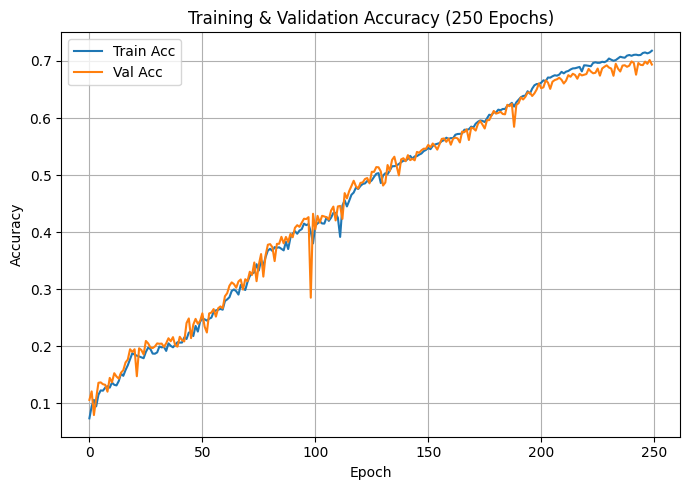


Classification Report (All SNRs):
              precision    recall  f1-score   support

     128APSK       0.36      0.16      0.23      3000
      128QAM       0.42      0.49      0.45      3000
      16APSK       0.91      0.90      0.90      3000
       16PSK       0.86      0.76      0.81      3000
       16QAM       0.75      0.92      0.83      3000
      256QAM       0.92      0.74      0.82      3000
      32APSK       0.87      0.80      0.83      3000
       32PSK       0.98      0.97      0.98      3000
       32QAM       0.91      0.90      0.90      3000
        4ASK       0.63      0.56      0.60      3000
      64APSK       0.45      0.69      0.54      3000
       64QAM       0.60      0.84      0.70      3000
        8ASK       0.46      0.83      0.60      3000
        8PSK       0.63      0.90      0.74      3000
   AM-DSB-SC       0.39      0.15      0.22      3000
   AM-DSB-WC       1.00      1.00      1.00      3000
   AM-SSB-SC       0.66      0.60      0.63   

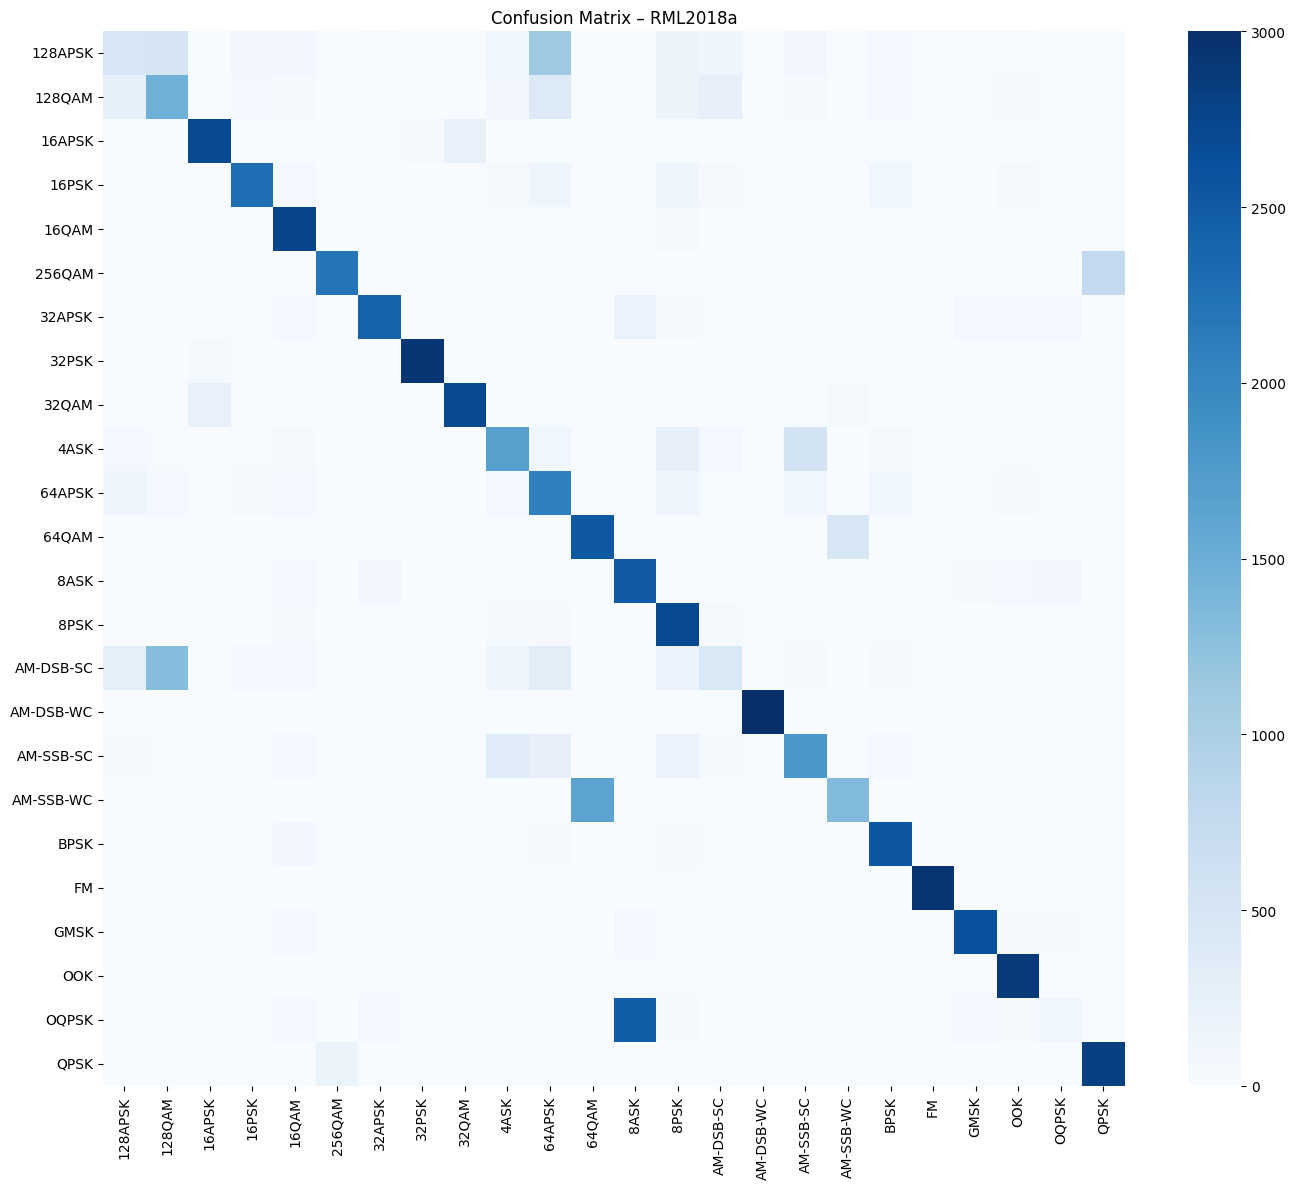

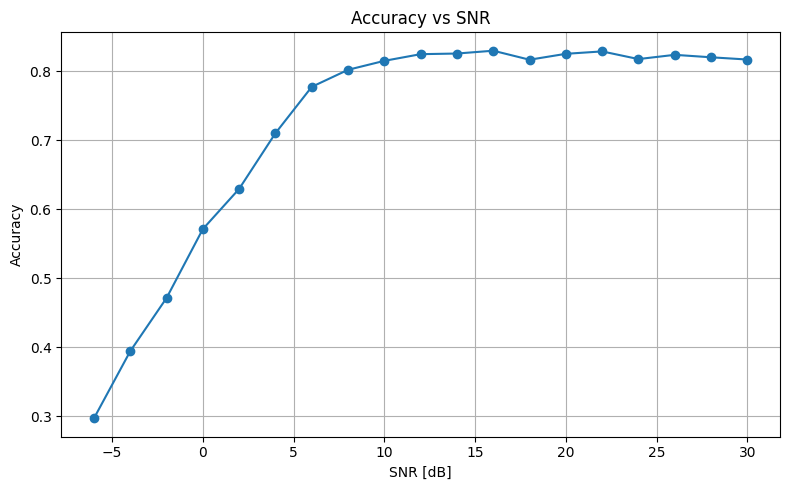


✅ Model saved to rml2018_lstm_model.keras


In [ ]:
import h5py, ast, numpy as np, tensorflow as tf, matplotlib.pyplot as plt, seaborn as sns, random
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from pathlib import Path

# --------------------------------------------------------------
# Resolve correct paths relative to the notebook location
# --------------------------------------------------------------
notebook_dir = Path().resolve()
project_root = notebook_dir.parent

data_dir = project_root / "data" / "RML2018" / "2018.01"
model_out = project_root / "models" / "rml2018_lstm_balanced.keras"

print("Notebook directory:", notebook_dir)
print("Data directory:", data_dir)
print("Model will be saved to:", model_out)

# -------------------- Parameters --------------------
MAX_SAMPLES_PER_CLASS = 3000
EPOCHS = 250
BATCH_SIZE = 64
LR = 1e-4
SNR_CUTOFF = -6  # Minimum SNR to include

# Updated paths
H5_PATH = data_dir / "GOLD_XYZ_OSC.0001_1024.hdf5"
CLASSES_PATH = data_dir / "classes.txt"

# -------------------- Load Dataset ---------------------
def load_rml2018_balanced(h5_path, classes_txt, max_per_class=3000, snr_cutoff=None):
    with open(classes_txt, "r") as f:
        class_list = ast.literal_eval(f.read().split("=")[-1].strip())
        class_list = [c.strip(" '") for c in class_list]

    with h5py.File(h5_path, "r") as f:
        X, Y, Z = f["X"][:], f["Y"][:], f["Z"][:]

    per_class = {cls: [] for cls in class_list}
    for i in range(len(X)):
        snr = int(Z[i][0])
        if snr_cutoff is None or snr >= snr_cutoff:
            label_idx = int(Y[i].argmax())
            cls = class_list[label_idx]
            sig = np.hstack([X[i], np.full((1024, 1), snr, dtype=np.float32)])
            per_class[cls].append((sig, snr))

    # Shuffle + trim
    for k in per_class:
        random.shuffle(per_class[k])
        per_class[k] = per_class[k][:max_per_class]

    X, y, snrs = [], [], []
    for cls, samples in per_class.items():
        for sig, snr in samples:
            X.append(sig)
            y.append(cls)
            snrs.append(snr)

    return np.array(X, dtype=np.float32), np.array(y), np.array(snrs), class_list

# Load dataset from correct location
X_all, y_all, snrs_all, class_list = load_rml2018_balanced(
    H5_PATH, CLASSES_PATH, MAX_SAMPLES_PER_CLASS, SNR_CUTOFF
)

# -------------------- Encode Labels ---------------------
le = LabelEncoder()
y_all_enc = le.fit_transform(y_all)
n_classes = len(le.classes_)
print(f"Classes ({n_classes}):", le.classes_)

# -------------------- Train/Val Split ---------------------
X_tr, X_val, y_tr, y_val = train_test_split(
    X_all, y_all_enc, test_size=0.2, stratify=y_all_enc, random_state=42
)

# -------------------- Build LSTM Model ---------------------
def build_model(input_shape, n_classes, lr=1e-4):
    model = Sequential([
        LSTM(128, input_shape=input_shape, return_sequences=True),
        Dropout(0.5),
        LSTM(128, return_sequences=False),
        Dropout(0.2),
        Dense(128, activation="relu"),
        Dropout(0.1),
        Dense(n_classes, activation="softmax")
    ])
    model.compile(
        optimizer=Adam(lr),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

model = build_model((1024, 3), n_classes, LR)
model.summary()

# -------------------- Train Model ---------------------
history = model.fit(
    X_tr, y_tr,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=2
)

# -------------------- Plot Accuracy ---------------------
plt.figure(figsize=(7, 5))
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy (250 Epochs)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# -------------------- Evaluate All ---------------------
y_prob = model.predict(X_all, verbose=0)
y_pred = np.argmax(y_prob, axis=1)

print("\nClassification Report (All SNRs):")
print(classification_report(y_all_enc, y_pred, target_names=le.classes_))

cm = confusion_matrix(y_all_enc, y_pred)
plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=False, cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix – RML2018a")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# -------------------- Accuracy per SNR ---------------------
snr_unique = sorted(np.unique(snrs_all))
acc_per_snr = [(y_pred[snrs_all == snr] == y_all_enc[snrs_all == snr]).mean() for snr in snr_unique]

plt.figure(figsize=(8, 5))
plt.plot(snr_unique, acc_per_snr, marker="o")
plt.title("Accuracy vs SNR")
plt.xlabel("SNR [dB]")
plt.ylabel("Accuracy")
plt.grid(True)
plt.tight_layout()
plt.show()

# -------------------- Save Model ---------------------
model.save(model_out)
print(f"\nModel saved to: {model_out}")
